# 📊 **ANALYSIS NOTEBOOK** 📊  
**Author:** *Luc Voorend*  
**Date:** *2025-05-20*

---

### 📘 **Description**  
This Jupyter notebook contains the code used to generate **all figures** in the *Results* section of the thesis.  
Its primary goal is to ensure **reproducibility** and to provide future Master's students working on this subject with clarity on **what exactly is shown in the graphs**.

> ⚠️ **Note:** The code has **not been cleaned or optimized** — it reflects the exact state used during the analysis phase.

---



In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import sqlite3 as sql

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

In [2]:
#===============SET PARAMETERS FOR CUSTOM PLOTTING====================#

# Set the inside ticks to be default
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

# Set font size of x and y labels to be 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set custom color cycle
custom_colors = [    
    '#0081C8',  # Olynmpic Blue
    '#EE334E',  # Olynmpic Red
    '#00A651',  # Olympic Green
    '#FCB131', # Olympic Yellow
    '#ba55d3',  # Medium Orchid
    '#00ced1',  # Dark Turquoise
    '#a89078', #Pastel brown
    '#e9967a',  # Dark Salmon
    '#66cdaa',   # Medium Aquamarine
    '#db7093'  # Pale Violet Red
]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

In [3]:
#===============FUNCTIONS====================#

# Function for binomial quantile confidence intervals, see thesis Appendix B.
def get_quantile_bounds(quantile = 0.5, N_samples = 1000):
    """
    Function to get the quantile bounds for a given quantile and number of samples:
        Assumes large enough sample size to approximate the quantile bounds of the binomial distribution with a normal distribution

    Input: 
    - quantile: float, the quantile to calculate the bounds for
    - N_samples: int, the number of samples to use in the calculation

    Output:
    - lower_bound: int, the index for lower bound of the quantile
    - upper_bound: int, the index for upper bound of the quantile
    """
    k_low = N_samples*quantile - np.sqrt(N_samples*quantile*(1-quantile))
    k_high = N_samples*quantile + np.sqrt(N_samples*quantile*(1-quantile))
    
    lower_bound = int(np.floor(k_low))
    upper_bound = int(np.ceil(k_high))
    
    return lower_bound, upper_bound

## 🔍 **Section 7.1: Event Selection**

In [8]:
# Load the predictions of the different models
# Predictions are done on all events in the validation set, no selection yet
pred_tc_cc = pd.read_csv('/groups/icecube/luc/Workspace/GraphNet/work/IceCube_transformer/predictions/22011/lepton_angle/TC_CC_101.csv')
pred_tc_cc_spline_less2 = pd.read_csv('/groups/icecube/luc/Workspace/GraphNet/work/IceCube_transformer/predictions/22011/lepton_angle/TC_CC_spline_less2_097.csv')
pred_spline_less2 = pd.read_csv("/groups/icecube/luc/Workspace/GraphNet/work/IceCube_transformer/predictions/22011/lepton_angle/Spline_less_2_081.csv")

# Load the selections sets to create selection masks
event_no_total = pred_tc_cc['event_no']
tc_cc_selection = pd.read_csv('/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/selection_files/snowstorm/22011/part_4/selection_CC_thorsten_cut.csv')
tc_cc_spline_less2_selection = pd.read_csv('/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/selection_files/snowstorm/22011/part_4/selection_TC_CC_Spline_less_2.csv')
spline_less2_selection = pd.read_csv("/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/selection_files/snowstorm/22011/part_4/val_selection_opening_angle_less_2.csv")

# Create the selection masks
tc_cc_selection_mask = event_no_total.isin(tc_cc_selection.to_numpy().flatten())
tc_cc_spline_less2_selection_mask = event_no_total.isin(tc_cc_spline_less2_selection.to_numpy().flatten())
spline_less2_selection_mask = event_no_total.isin(spline_less2_selection.to_numpy().flatten())

# Print some information about the selection sets
print(f"Total number of events in the validation set: {len(event_no_total)} (22011 part 4)")
print("===================================================================")
print(f"Number of events passing the Thorsten Cut: {sum(tc_cc_selection_mask)}")
print(f"Number of events passing the Spline less than 2 cut: {sum(spline_less2_selection_mask)}")
print(f"Number of events passing the TC_CC Spline less than 2 cut: {sum(tc_cc_spline_less2_selection_mask)}")

Total number of events in the validation set: 404014 (22011 part 4)
Number of events passing the Thorsten Cut: 237392
Number of events passing the Spline less than 2 cut: 164579
Number of events passing the TC_CC Spline less than 2 cut: 134060


In [10]:
# Calculate the opening angles for the different models

# Select truth x, y, z from one of the prediction files (all files have the same truth values)
x_truth = pred_tc_cc['x_truth']
y_truth = pred_tc_cc['y_truth']
z_truth = pred_tc_cc['z_truth']

# Thorsten cut
x_tc_cc = pred_tc_cc['x_pred']
y_tc_cc = pred_tc_cc['y_pred']
z_tc_cc = pred_tc_cc['z_pred']

cos_opening_angle_tc_cc = (x_truth*x_tc_cc + y_truth*y_tc_cc + z_truth*z_tc_cc) / (np.sqrt(x_truth**2 + y_truth**2 + z_truth**2) * np.sqrt(x_tc_cc**2 + y_tc_cc**2 + z_tc_cc**2))
opening_angle_tc_cc = np.arccos(cos_opening_angle_tc_cc)
opening_angle_tc_cc = np.degrees(opening_angle_tc_cc)

# Spline less than 2 and Thorsten Cut
x_tc_cc_spline_less2 = pred_tc_cc_spline_less2['x_pred']
y_tc_cc_spline_less2 = pred_tc_cc_spline_less2['y_pred']
z_tc_cc_spline_less2 = pred_tc_cc_spline_less2['z_pred']

cos_opening_angle_tc_cc_spline_less2 = (x_truth*x_tc_cc_spline_less2 + y_truth*y_tc_cc_spline_less2 + z_truth*z_tc_cc_spline_less2) / (np.sqrt(x_truth**2 + y_truth**2 + z_truth**2) * np.sqrt(x_tc_cc_spline_less2**2 + y_tc_cc_spline_less2**2 + z_tc_cc_spline_less2**2))
opening_angle_tc_cc_spline_less2 = np.arccos(cos_opening_angle_tc_cc_spline_less2)
opening_angle_tc_cc_spline_less2 = np.degrees(opening_angle_tc_cc_spline_less2)

# Spline less than 2
x_spline_less_2 = pred_spline_less2['x_pred']
y_spline_less_2 = pred_spline_less2['y_pred']
z_spline_less_2 = pred_spline_less2['z_pred']

cos_opening_angle_spline_less_2 = (x_truth*x_spline_less_2 + y_truth*y_spline_less_2 + z_truth*z_spline_less_2) / (np.sqrt(x_truth**2 + y_truth**2 + z_truth**2) * np.sqrt(x_spline_less_2**2 + y_spline_less_2**2 + z_spline_less_2**2))
opening_angle_spline_less_2 = np.arccos(cos_opening_angle_spline_less_2)
opening_angle_spline_less_2 = np.degrees(opening_angle_spline_less_2)

### 

### 🖼️ **Figure 7.1**  
**Distribution of the opening angle** between the true lepton direction and the reconstructed lepton direction for models trained with different selection cuts on the training set.  
The models are validated on the same **uncut and uncleaned** validation set.  
The **median** of the models is indicated with a **dashed line** in the zoomed-in plot.


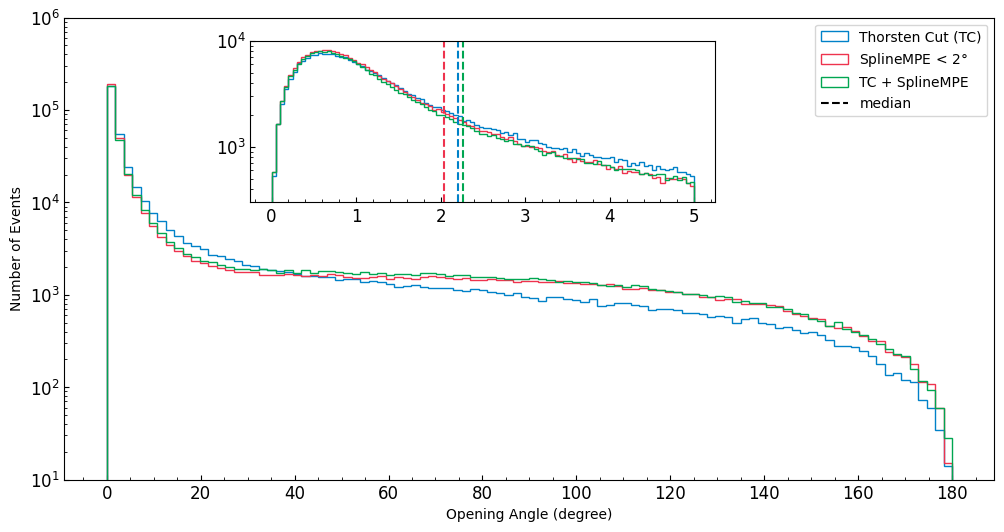

In [12]:
# Plot the distribution of the opening angles for the different models with the selection cuts

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(opening_angle_tc_cc, bins=100, histtype='step', label='Thorsten Cut (TC)', range=(0, 180))
ax.hist(opening_angle_spline_less_2, bins=100, histtype='step', label='SplineMPE < $2\\degree$', range=(0, 180))
ax.hist(opening_angle_tc_cc_spline_less2, bins=100, histtype='step', label='TC + SplineMPE', range=(0, 180))
ax.set_xlabel('Opening Angle (degree)')
ax.set_ylabel('Number of Events')

ax.set_yscale('log')
ax.set_ylim(10, 1e6)

# add a black dashed line to the legend with label "median"
ax.plot([], linestyle='--', color='black', label='median')
ax.legend()

# add a second plot with the same x-axis and y-axis
ax2 = ax.inset_axes([0.2, 0.6, 0.5, 0.35])  # [x, y, width, height]
ax2.hist(opening_angle_tc_cc, bins=100, histtype='step', label='TC_CC', range=(0, 5))
ax2.hist(opening_angle_spline_less_2, bins=100, histtype='step', label='Spline_less_2', range=(0, 5))
ax2.hist(opening_angle_tc_cc_spline_less2, bins=100, histtype='step', label='TC_CC_spline_less2', range=(0, 5))
ax2.set_yscale('log')

# Set the y-axis limits for the inset plot
ax2.set_ylim(300, 1e4)

ax2.axvline(opening_angle_tc_cc.median(), color=custom_colors[0], linestyle='--')
ax2.axvline(opening_angle_spline_less_2.median(), color=custom_colors[1], linestyle='--')
ax2.axvline(opening_angle_tc_cc_spline_less2.median(), color=custom_colors[2], linestyle='--')

# ticks on primare axis every 20 degrees
ax.set_xticks(np.arange(0, 181, 20))

plt.show()

### 🖼️ **Figure 7.2**  
**2D Histograms of Angular Error Distributions**  

This figure presents **2D histograms** showing the **zenith** and **azimuthal angle error** distributions for various **event selection cuts**.  
The angle error is defined as **ψ<sub>true</sub> − ψ<sub>pred</sub>**.  
The **red cross** marks the **mode of the distribution**.


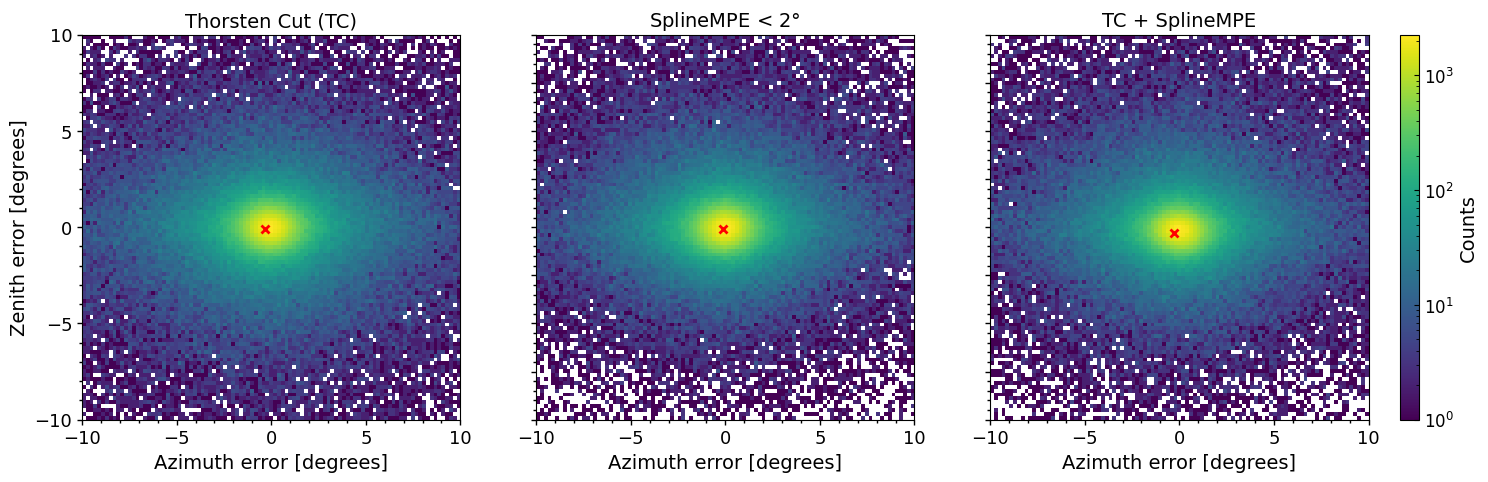

In [16]:
# plot a 2D heatmap of azimuth and zenith opening angle for the three models
zenith_pred_tc_cc = np.arccos(z_tc_cc/np.sqrt(x_tc_cc**2 + y_tc_cc**2 + z_tc_cc**2))
zenith_truth = np.arccos(z_truth/np.sqrt(x_truth**2 + y_truth**2 + z_truth**2))
zenith_error_tc_cc = np.degrees(zenith_truth - zenith_pred_tc_cc)
azimuth_pred_tc_cc = np.arctan2(y_tc_cc, x_tc_cc)
azimuth_truth = np.arctan2(y_truth, x_truth)
azimuth_error_tc_cc = np.degrees(azimuth_truth - azimuth_pred_tc_cc)
# make sure azimuth error is between -180 and 180
azimuth_error_tc_cc = np.where(azimuth_error_tc_cc > 180, azimuth_error_tc_cc - 360, azimuth_error_tc_cc)

zenith_pred_tc_cc_spline_less2 = np.arccos(z_tc_cc_spline_less2/np.sqrt(x_tc_cc_spline_less2**2 + y_tc_cc_spline_less2**2 + z_tc_cc_spline_less2**2))
zenith_error_tc_cc_spline_less2 = np.degrees(zenith_truth - zenith_pred_tc_cc_spline_less2)
azimuth_pred_tc_cc_spline_less2 = np.arctan2(y_tc_cc_spline_less2, x_tc_cc_spline_less2)
azimuth_error_tc_cc_spline_less2 = np.degrees(azimuth_truth - azimuth_pred_tc_cc_spline_less2)
# make sure azimuth error is between -180 and 180
azimuth_error_tc_cc_spline_less2 = np.where(azimuth_error_tc_cc_spline_less2 > 180, azimuth_error_tc_cc_spline_less2 - 360, azimuth_error_tc_cc_spline_less2)

zenith_pred_spline_less_2 = np.arccos(z_spline_less_2/np.sqrt(x_spline_less_2**2 + y_spline_less_2**2 + z_spline_less_2**2))
zenith_error_spline_less_2 = np.degrees(zenith_truth - zenith_pred_spline_less_2)
azimuth_pred_spline_less_2 = np.arctan2(y_spline_less_2, x_spline_less_2)
azimuth_error_spline_less_2 = np.degrees(azimuth_truth - azimuth_pred_spline_less_2)
# make sure azimuth error is between -180 and 180
azimuth_error_spline_less_2 = np.where(azimuth_error_spline_less_2 > 180, azimuth_error_spline_less_2 - 360, azimuth_error_spline_less_2)

# plot the zenith and azimuth error for the three models
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# plot zenith error
zenith_bins = np.linspace(-10, 10, 100)
azimuth_bins = np.linspace(-10, 10, 100)
H_tc_cc, xedges, yedges = np.histogram2d(zenith_error_tc_cc, azimuth_error_tc_cc, bins=(zenith_bins, azimuth_bins))
H_tc_cc_spline_less2, xedges, yedges = np.histogram2d(zenith_error_tc_cc_spline_less2, azimuth_error_tc_cc_spline_less2, bins=(zenith_bins, azimuth_bins))
H_spline_less_2, xedges, yedges = np.histogram2d(zenith_error_spline_less_2, azimuth_error_spline_less_2, bins=(zenith_bins, azimuth_bins))

# find the mode of each histogram
H_tc_cc_mode = np.unravel_index(np.argmax(H_tc_cc), H_tc_cc.shape)
H_tc_cc_spline_less2_mode = np.unravel_index(np.argmax(H_tc_cc_spline_less2), H_tc_cc_spline_less2.shape)
H_spline_less_2_mode = np.unravel_index(np.argmax(H_spline_less_2), H_spline_less_2.shape)

# convert modes to zenith and azimuth errors
zenith_tc_cc_mode = yedges[H_tc_cc_mode[0]]
azimuth_tc_cc_mode = xedges[H_tc_cc_mode[1]]

zenith_tc_cc_spline_less2_mode = yedges[H_tc_cc_spline_less2_mode[0]]
azimuth_tc_cc_spline_less2_mode = xedges[H_tc_cc_spline_less2_mode[1]]

zenith_spline_less_2_mode = yedges[H_spline_less_2_mode[0]]
azimuth_spline_less_2_mode = xedges[H_spline_less_2_mode[1]]


# make the histograms masked where the value is 0
H_tc_cc = np.ma.masked_where(H_tc_cc == 0, H_tc_cc)
H_tc_cc_spline_less2 = np.ma.masked_where(H_tc_cc_spline_less2 == 0, H_tc_cc_spline_less2)
H_spline_less_2 = np.ma.masked_where(H_spline_less_2 == 0, H_spline_less_2)
# plot the histograms (zenith on y-axis, azimuth on x-axis)
axs[0].pcolormesh(yedges, xedges, H_tc_cc, cmap='viridis', norm=colors.LogNorm())
# plot a red cross at the mode of the histogram with a thickness of 2
axs[0].plot(azimuth_tc_cc_mode, zenith_tc_cc_mode, 'rx', markersize=6, markeredgewidth=2)
axs[0].set_xlabel('Azimuth error [degrees]', fontsize=14)
axs[0].set_ylabel('Zenith error [degrees]', fontsize=14)
axs[0].set_title('Thorsten Cut (TC)', fontsize=14)
axs[0].set_xlim(-10, 10)

# set y_ticks -10, -5, 0, 5, 10
axs[0].set_yticks(np.arange(-10, 11, 5))

# plot the histograms
axs[2].pcolormesh(yedges, xedges, H_tc_cc_spline_less2, cmap='viridis', norm=colors.LogNorm())
# plot a red cross at the mode of the histogram with a thickness of 2
axs[2].plot(azimuth_tc_cc_spline_less2_mode, zenith_tc_cc_spline_less2_mode, 'rx', markersize=6, markeredgewidth=2)
axs[2].set_xlabel('Azimuth error [degrees]', fontsize=14)
axs[2].set_title('TC + SplineMPE', fontsize=14)
axs[2].set_xlim(-10, 10)

axs[1].set_yticklabels([])

axs[1].pcolormesh(yedges, xedges, H_spline_less_2, cmap='viridis', norm=colors.LogNorm())
# plot a red cross at the mode of the histogram with a thickness of 2
axs[1].plot(azimuth_spline_less_2_mode, zenith_spline_less_2_mode, 'rx', markersize=6, markeredgewidth=2)
axs[1].set_xlabel('Azimuth error [degrees]', fontsize=14)
axs[1].set_title('SplineMPE < 2$\\degree$', fontsize=14)
axs[1].set_xlim(-10, 10)

axs[2].set_yticklabels([])

# set plot to use outer ticks
axs[0].tick_params(axis='both',  direction='out',  width=1, colors='black', labelsize=12)
axs[1].tick_params(axis='both',  direction='out',  width=1, colors='black', labelsize=12)
axs[2].tick_params(axis='both',  direction='out',  width=1, colors='black', labelsize=12)

# minor ticks
axs[0].tick_params(axis='both', which='minor', direction='out', width=1, colors='black')
axs[1].tick_params(axis='both', which='minor', direction='out', width=1, colors='black')
axs[2].tick_params(axis='both', which='minor', direction='out', width=1, colors='black')

# set tick label fontsize
axs[0].tick_params(axis='both', labelsize=13)
axs[1].tick_params(axis='both', labelsize=13)
axs[2].tick_params(axis='both', labelsize=13)

# add colorbar
cbar = fig.colorbar(axs[0].collections[0], ax=axs, orientation='vertical', pad=0.02)
cbar.set_label('Counts', fontsize=14)

plt.show()

In [17]:
# Load truth information for binned performance
truth_parquet = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/22011/truth_4.parquet"
truth = pd.read_parquet(truth_parquet)

true_energy = truth['energy']
zenith_truth = truth['zenith']
azimuth_truth = truth['azimuth']

### 🖼️ **Figure 7.3**  
**Median Opening Angle vs. Neutrino Energy**  

Median opening angle as a function of neutrino energy for models with different training selection cuts. Dots indicate the sample median, and shaded bands indicate the 1σ confidence interval on this median.



In [19]:
# plot the median opening angle as a function of true energy for TC_CC, TC_CC_spline_less2 and Spline_less_2
energy_bins = np.logspace(4, 6, 9)
median_opening_angle_tc_cc = np.zeros(len(energy_bins)-1)
median_opening_angle_tc_cc_spline_less2 = np.zeros(len(energy_bins)-1)
median_opening_angle_spline_less_2 = np.zeros(len(energy_bins)-1)

# also track the 1 sigma uncertainty on the median
lower_bound_tc_cc = np.zeros(len(energy_bins)-1)
upper_bound_tc_cc = np.zeros(len(energy_bins)-1)
lower_bound_tc_cc_spline_less2 = np.zeros(len(energy_bins)-1)
upper_bound_tc_cc_spline_less2 = np.zeros(len(energy_bins)-1)
lower_bound_spline_less_2 = np.zeros(len(energy_bins)-1)
upper_bound_spline_less_2 = np.zeros(len(energy_bins)-1)

for i in range(len(energy_bins)-1):
    energy_mask = (true_energy > energy_bins[i]) & (true_energy <= energy_bins[i+1])
    # median without selection
    median_opening_angle_tc_cc[i] = opening_angle_tc_cc[energy_mask].median()
    median_opening_angle_tc_cc_spline_less2[i] = opening_angle_tc_cc_spline_less2[energy_mask].median()
    median_opening_angle_spline_less_2[i] = opening_angle_spline_less_2[energy_mask].median()

    counts = np.sum(energy_mask)
    # calculate the 1 sigma uncertainty on the median by using the quantile bounds function
    quantile = 0.5
    N_samples = counts

    k_low = N_samples*quantile - np.sqrt(N_samples*quantile*(1-quantile))
    k_high = N_samples*quantile + np.sqrt(N_samples*quantile*(1-quantile))

    sorted_opening_angle_tc_cc = np.sort(opening_angle_tc_cc[energy_mask])
    sorted_opening_angle_tc_cc_spline_less2 = np.sort(opening_angle_tc_cc_spline_less2[energy_mask])
    sorted_opening_angle_spline_less_2 = np.sort(opening_angle_spline_less_2[energy_mask])

    lower_bound_tc_cc[i] = sorted_opening_angle_tc_cc[int(k_low)]
    upper_bound_tc_cc[i] = sorted_opening_angle_tc_cc[int(k_high)]

    lower_bound_tc_cc_spline_less2[i] = sorted_opening_angle_tc_cc_spline_less2[int(k_low)]
    upper_bound_tc_cc_spline_less2[i] = sorted_opening_angle_tc_cc_spline_less2[int(k_high)]

    lower_bound_spline_less_2[i] = sorted_opening_angle_spline_less_2[int(k_low)]
    upper_bound_spline_less_2[i] = sorted_opening_angle_spline_less_2[int(k_high)]

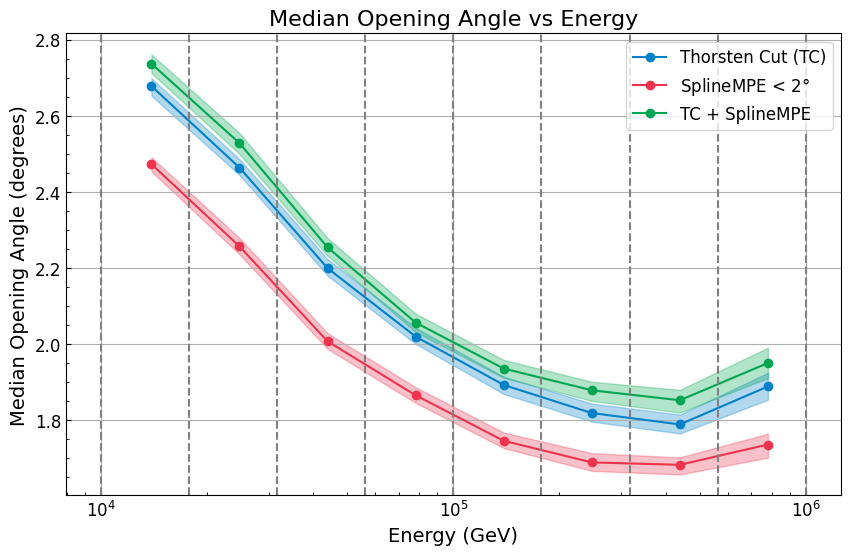

In [21]:
# Plot the median opening angle as a function of energy
fig, ax = plt.subplots(figsize=(10, 6))
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
ax.plot(bin_centers, median_opening_angle_tc_cc, label='Thorsten Cut (TC)', marker='o')
ax.plot(bin_centers, median_opening_angle_spline_less_2, label='SplineMPE < 2$\\degree$', marker='o')
ax.plot(bin_centers, median_opening_angle_tc_cc_spline_less2, label='TC + SplineMPE', marker='o')

# color uncertainty bands in the same color as the lines
ax.fill_between(bin_centers, lower_bound_tc_cc, upper_bound_tc_cc, color=custom_colors[0], alpha=0.3)
ax.fill_between(bin_centers, lower_bound_tc_cc_spline_less2, upper_bound_tc_cc_spline_less2, color=custom_colors[2], alpha=0.3)
ax.fill_between(bin_centers, lower_bound_spline_less_2, upper_bound_spline_less_2, color=custom_colors[1], alpha=0.3)
ax.set_xlabel("Energy (GeV)", fontsize=14)
ax.set_ylabel("Median Opening Angle (degrees)", fontsize=14)
ax.set_xscale('log')
# legend upper right
ax.legend(loc='upper right', fontsize=12)
# add dashed lines for bin edges
for i in range(len(energy_bins)):
    ax.axvline(energy_bins[i], color='gray', linestyle='--')

ax.grid()
ax.set_title("Median Opening Angle vs Energy", fontsize=16)

# x and y labels to fontsize 14
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.show()

### 🖼️ **Figure 7.4**  
**Median Opening Angle vs. True Azimuthal Direction**  

Median opening angle as a function of true azimuthal direction for models with different training selection cuts. Dots indicate the sample median, and shaded bands indicate the 1σ confidence interval on this median.


In [25]:
# median opening angle binned in true azimuth
azimuth_bins = np.linspace(0, 2*np.pi, 10)
median_opening_angle_tc_cc_azimuth = np.zeros(len(azimuth_bins)-1)
median_opening_angle_spline_less_2_azimuth = np.zeros(len(azimuth_bins)-1)
median_opening_angle_tc_cc_spline_less2_azimuth = np.zeros(len(azimuth_bins)-1)
lower_bound_tc_cc_azimuth = np.zeros(len(azimuth_bins)-1)
upper_bound_tc_cc_azimuth = np.zeros(len(azimuth_bins)-1)
lower_bound_tc_cc_spline_less2_azimuth = np.zeros(len(azimuth_bins)-1)
upper_bound_tc_cc_spline_less2_azimuth = np.zeros(len(azimuth_bins)-1)
lower_bound_spline_less_2_azimuth = np.zeros(len(azimuth_bins)-1)
upper_bound_spline_less_2_azimuth = np.zeros(len(azimuth_bins)-1)

for i in range(len(azimuth_bins)-1):
    azimuth_mask = (azimuth_truth > azimuth_bins[i]) & (azimuth_truth <= azimuth_bins[i+1])
    # median without selection
    median_opening_angle_tc_cc_azimuth[i] = opening_angle_tc_cc[azimuth_mask].median()
    median_opening_angle_tc_cc_spline_less2_azimuth[i] = opening_angle_tc_cc_spline_less2[azimuth_mask].median()
    median_opening_angle_spline_less_2_azimuth[i] = opening_angle_spline_less_2[azimuth_mask].median()

    counts = np.sum(azimuth_mask)
    # calculate the 1 sigma uncertainty on the median by using the quantile bounds function
    quantile = 0.5
    N_samples = counts

    k_low = N_samples*quantile - np.sqrt(N_samples*quantile*(1-quantile))
    k_high = N_samples*quantile + np.sqrt(N_samples*quantile*(1-quantile))

    sorted_opening_angle_tc_cc = np.sort(opening_angle_tc_cc[azimuth_mask])
    sorted_opening_angle_tc_cc_spline_less2 = np.sort(opening_angle_tc_cc_spline_less2[azimuth_mask])
    sorted_opening_angle_spline_less_2 = np.sort(opening_angle_spline_less_2[azimuth_mask])

    lower_bound_tc_cc_azimuth[i] = sorted_opening_angle_tc_cc[int(k_low)]
    upper_bound_tc_cc_azimuth[i] = sorted_opening_angle_tc_cc[int(k_high)]

    lower_bound_tc_cc_spline_less2_azimuth[i] = sorted_opening_angle_tc_cc_spline_less2[int(k_low)]
    upper_bound_tc_cc_spline_less2_azimuth[i] = sorted_opening_angle_tc_cc_spline_less2[int(k_high)]

    lower_bound_spline_less_2_azimuth[i] = sorted_opening_angle_spline_less_2[int(k_low)]
    upper_bound_spline_less_2_azimuth[i] = sorted_opening_angle_spline_less_2[int(k_high)]


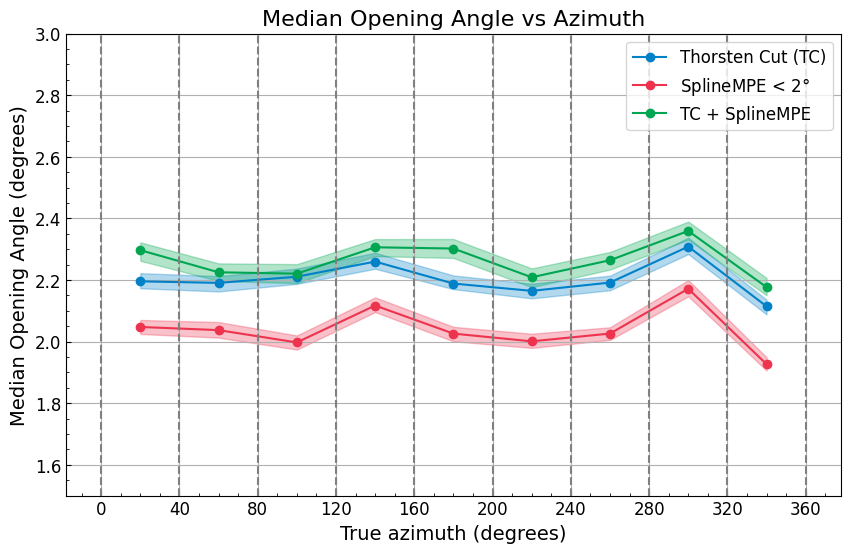

In [26]:
# Plot the median opening angle as a function of azimuth
fig, ax = plt.subplots(figsize=(10, 6))
bin_centers = (azimuth_bins[:-1] + azimuth_bins[1:]) / 2
bin_centers = np.degrees(bin_centers)
ax.plot(bin_centers, median_opening_angle_tc_cc_azimuth, label='Thorsten Cut (TC)', marker='o')
ax.plot(bin_centers, median_opening_angle_spline_less_2_azimuth, label='SplineMPE < 2$\\degree$', marker='o')
ax.plot(bin_centers, median_opening_angle_tc_cc_spline_less2_azimuth, label='TC + SplineMPE', marker='o')
# color uncertainty bands in the same color as the lines
ax.fill_between(bin_centers, lower_bound_tc_cc_azimuth, upper_bound_tc_cc_azimuth, color=custom_colors[0], alpha=0.3)
ax.fill_between(bin_centers, lower_bound_tc_cc_spline_less2_azimuth, upper_bound_tc_cc_spline_less2_azimuth, color=custom_colors[2], alpha=0.3)
ax.fill_between(bin_centers, lower_bound_spline_less_2_azimuth, upper_bound_spline_less_2_azimuth, color=custom_colors[1], alpha=0.3)
ax.set_xlabel("True azimuth (degrees)", fontsize=14)
ax.set_ylabel("Median Opening Angle (degrees)", fontsize=14)
ax.set_title("Median Opening Angle vs Azimuth", fontsize=16)
ax.set_ylim(1.5, 3)
# dashed lines for bin edges
for i in range(len(azimuth_bins)):
    ax.axvline(np.degrees(azimuth_bins[i]), color='gray', linestyle='--')
ax.legend(loc='upper right', fontsize=12)
# set x-ticks every 40 degrees
ax.set_xticks(np.arange(-0, 361, 40))
ax.grid()
# x and y labels to fontsize 14
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.show()

### 🖼️ **Figure 7.5**  
**Median Opening Angle vs. True Zenith Direction**  

Median opening angle as a function of true zenith direction for models with different training selection cuts. Dots indicate the sample median, and shaded bands indicate the 1σ confidence interval on this median.


In [22]:
# make a plot binned in true zenith
zenith_bins = np.linspace(0, np.pi, 10)
median_opening_angle_tc_cc_zenith = np.zeros(len(zenith_bins)-1)
median_opening_angle_spline_less_2_zenith = np.zeros(len(zenith_bins)-1)
median_opening_angle_tc_cc_spline_less2_zenith = np.zeros(len(zenith_bins)-1)

lower_bound_tc_cc_zenith = np.zeros(len(zenith_bins)-1)
upper_bound_tc_cc_zenith = np.zeros(len(zenith_bins)-1)

lower_bound_tc_cc_spline_less2_zenith = np.zeros(len(zenith_bins)-1)
upper_bound_tc_cc_spline_less2_zenith = np.zeros(len(zenith_bins)-1)

lower_bound_spline_less_2_zenith = np.zeros(len(zenith_bins)-1)
upper_bound_spline_less_2_zenith = np.zeros(len(zenith_bins)-1)

for i in range(len(zenith_bins)-1):
    zenith_mask = (zenith_truth > zenith_bins[i]) & (zenith_truth <= zenith_bins[i+1])
    # median without selection
    median_opening_angle_tc_cc_zenith[i] = opening_angle_tc_cc[zenith_mask].median()
    median_opening_angle_tc_cc_spline_less2_zenith[i] = opening_angle_tc_cc_spline_less2[zenith_mask].median()
    median_opening_angle_spline_less_2_zenith[i] = opening_angle_spline_less_2[zenith_mask].median()

    counts = np.sum(zenith_mask)
    # calculate the 1 sigma uncertainty on the median by using the quantile bounds function
    quantile = 0.5
    N_samples = counts

    k_low = N_samples*quantile - np.sqrt(N_samples*quantile*(1-quantile))
    k_high = N_samples*quantile + np.sqrt(N_samples*quantile*(1-quantile))

    sorted_opening_angle_tc_cc = np.sort(opening_angle_tc_cc[zenith_mask])
    sorted_opening_angle_tc_cc_spline_less2 = np.sort(opening_angle_tc_cc_spline_less2[zenith_mask])
    sorted_opening_angle_spline_less_2 = np.sort(opening_angle_spline_less_2[zenith_mask])

    lower_bound_tc_cc_zenith[i] = sorted_opening_angle_tc_cc[int(k_low)]
    upper_bound_tc_cc_zenith[i] = sorted_opening_angle_tc_cc[int(k_high)]

    lower_bound_tc_cc_spline_less2_zenith[i] = sorted_opening_angle_tc_cc_spline_less2[int(k_low)]
    upper_bound_tc_cc_spline_less2_zenith[i] = sorted_opening_angle_tc_cc_spline_less2[int(k_high)]

    lower_bound_spline_less_2_zenith[i] = sorted_opening_angle_spline_less_2[int(k_low)]
    upper_bound_spline_less_2_zenith[i] = sorted_opening_angle_spline_less_2[int(k_high)]

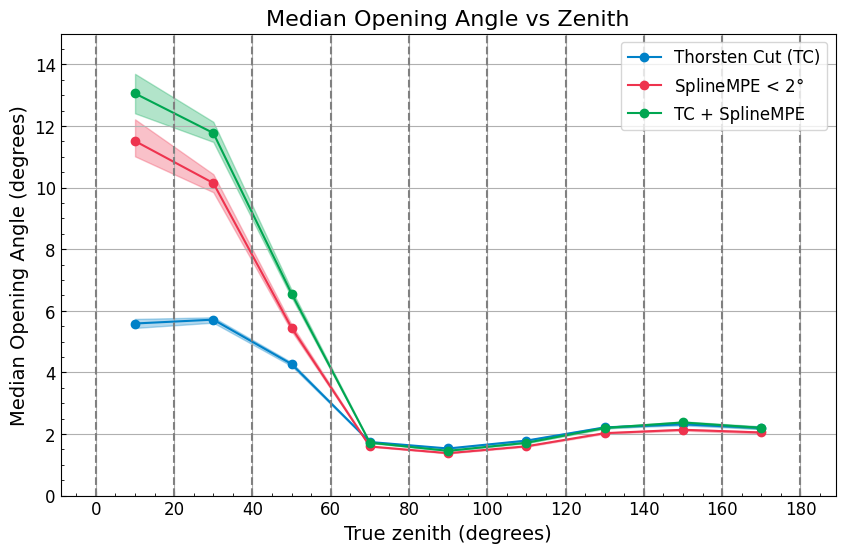

In [24]:
# Plot the median opening angle as a function of zenith
fig, ax = plt.subplots(figsize=(10, 6))
bin_centers = (zenith_bins[:-1] + zenith_bins[1:]) / 2

bin_centers = np.degrees(bin_centers)
ax.plot(bin_centers, median_opening_angle_tc_cc_zenith, label='Thorsten Cut (TC)', marker='o')
ax.plot(bin_centers, median_opening_angle_spline_less_2_zenith, label='SplineMPE < 2$\\degree$', marker='o')
ax.plot(bin_centers, median_opening_angle_tc_cc_spline_less2_zenith, label='TC + SplineMPE', marker='o')
# color uncertainty bands in the same color as the lines
ax.fill_between(bin_centers, lower_bound_tc_cc_zenith, upper_bound_tc_cc_zenith, color=custom_colors[0], alpha=0.3)
ax.fill_between(bin_centers, lower_bound_tc_cc_spline_less2_zenith, upper_bound_tc_cc_spline_less2_zenith, color=custom_colors[2], alpha=0.3)
ax.fill_between(bin_centers, lower_bound_spline_less_2_zenith, upper_bound_spline_less_2_zenith, color=custom_colors[1], alpha=0.3)
ax.set_xlabel("True zenith (degrees)", fontsize=14)
ax.set_ylabel("Median Opening Angle (degrees)", fontsize=14)
ax.set_title("Median Opening Angle vs Zenith", fontsize=16)
ax.set_ylim(0, 15)
# dashed lines for bin edges
for i in range(len(zenith_bins)):
    ax.axvline(np.degrees(zenith_bins[i]), color='gray', linestyle='--')
ax.legend(loc='upper right', fontsize=12)
# set x-ticks every 20 degrees
ax.set_xticks(np.arange(0, 181, 20))

# x and y labels to fontsize 14
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.grid()
plt.show()

### 🖼️ **Figure 7.6**  
**Opening Angle Distribution on Matched Selection**  

Distribution of the opening angle between the true lepton direction and the reconstructed lepton direction for models trained with different selection cuts on the training set. The models are validated on the subset of the total validation set that meets the same selection criteria as the training events. The distribution has significantly smaller tails than when validated on the raw validation set.


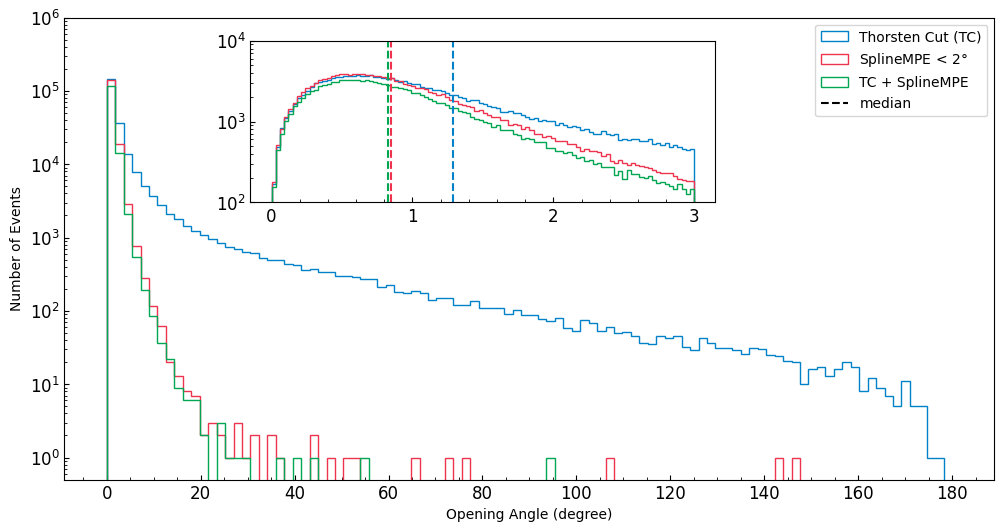

In [28]:
# repeat with selection masks
opening_angle_tc_cc_selection = opening_angle_tc_cc[tc_cc_selection_mask]
opening_angle_tc_cc_spline_less2_selection = opening_angle_tc_cc_spline_less2[tc_cc_spline_less2_selection_mask]
opening_angle_spline_less_2_selection = opening_angle_spline_less_2[spline_less2_selection_mask]

# put the second plot as a mini-plot inside the first plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(opening_angle_tc_cc_selection, bins=100, histtype='step', label='Thorsten Cut (TC)', range=(0, 180))
ax.hist(opening_angle_spline_less_2_selection, bins=100, histtype='step', label='SplineMPE < $2\\degree$', range=(0, 180))
ax.hist(opening_angle_tc_cc_spline_less2_selection, bins=100, histtype='step', label='TC + SplineMPE', range=(0, 180))
ax.set_xlabel('Opening Angle (degree)')
ax.set_ylabel('Number of Events')
ax.set_yscale('log')
ax.set_ylim(0.5, 1e6)

# add a black dashed line to the legend with label "median"
ax.plot([], linestyle='--', color='black', label='median')
ax.legend()

# add a second plot with the same x-axis and y-axis
ax2 = ax.inset_axes([0.2, 0.6, 0.5, 0.35])  # [x, y, width, height]
ax2.hist(opening_angle_tc_cc_selection, bins=100, histtype='step', label='TC_CC', range=(0, 3))
ax2.hist(opening_angle_spline_less_2_selection, bins=100, histtype='step', label='Spline_less_2', range=(0, 3))
ax2.hist(opening_angle_tc_cc_spline_less2_selection, bins=100, histtype='step', label='TC_CC_spline_less2', range=(0, 3))

ax2.set_yscale('log')
ax2.set_ylim(100, 1e4)

ax2.axvline(opening_angle_tc_cc_selection.median(), color=custom_colors[0], linestyle='--')
ax2.axvline(opening_angle_spline_less_2_selection.median(), color=custom_colors[1], linestyle='--')
ax2.axvline(opening_angle_tc_cc_spline_less2_selection.median(), color=custom_colors[2], linestyle='--')

# x ticks every degree
ax2.set_xticks(np.arange(0, 4, 1))

# ticks on primare axis every 20 degrees
ax.set_xticks(np.arange(0, 181, 20))
plt.show()

## 📈 **Section 7.2: Transformer Scaling Laws**

In [29]:
# Load performance for validation opening angle as function of data set size

# Local analysis with values directly copied
data_sizes = [100_000, 300_000, 500_000, 1_000_000, 2_000_000]
val_opening_angles = [2.7255570888519287, 1.9268136024475098, 1.6703494787216187, 1.4328579902648926, 1.2474106550216675]

### 🖼️ **Figure 7.7**  
**Scaling of Angular Reconstruction with Training Set Size**  

Performance of angular reconstruction for high energy IceCube events improves with increasing training set size. The performance follows a power law scaling, shown with a fit in red.


Power law fit: a=63.66053589685372, b=-0.27502232786116215


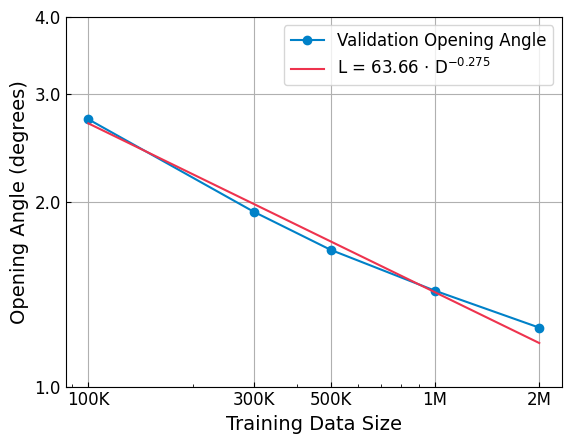

In [32]:
# fit a power law to the data
from scipy.optimize import curve_fit
def power_law(x, a, b):
    return a *x**b

popt, pcov = curve_fit(power_law, data_sizes, val_opening_angles)
print(f"Power law fit: a={popt[0]}, b={popt[1]}")

# plot the power law fit
plt.figure()
plt.plot(data_sizes, val_opening_angles, marker='o',label="Validation Opening Angle")
# plot the power law fit, print the equation in the legend using superscript for the exponent
plt.plot(data_sizes, power_law(np.array(data_sizes), *popt), label=r'L = %.2f $\cdot$ D$^{%.3f}$' % tuple(popt))
plt.xlabel("Training Data Size", fontsize=14)
plt.ylabel("Opening Angle (degrees)", fontsize=14)
plt.legend(fontsize=12)

plt.yscale("log")
plt.xscale("log")
plt.grid()
xticks = [100_000, 300_000, 500_000, 1_000_000, 2_000_000]
xlabels = ["100K", "300K", "500K", "1M", "2M"]
yticks = [1.0,2.0,3.0,4.0]
plt.yticks(yticks, yticks)
plt.xticks(xticks, xlabels)

# enable minor ticks on y-axis
plt.minorticks_on()

plt.show()

### 🖼️ **Figure 7.8**  
**Log-Scaled Dataset Size vs. Angular Reconstruction Performance**  

Performance of angular reconstruction for high energy IceCube events as a function of dataset size, scaled with a natural logarithm and shifted on the x-axis. The data points are fit with an exponential decay plus a constant to get a rough estimate of the model capacity limitation L(N).



Exponential decay fit: a=1.5774235564653079, b=0.22940942010849172, c=-0.5696819618082192


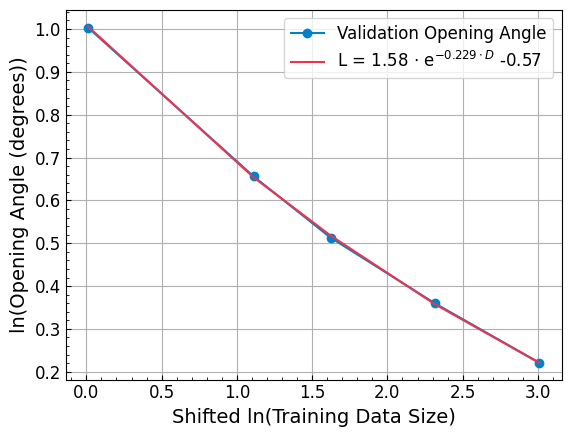

In [31]:
log_val_opening_angles = np.log(val_opening_angles)
log_data_sizes = np.log(data_sizes)

log_data_sizes = log_data_sizes - 11.5*np.ones(len(log_data_sizes))

# fit an exponential decay with a constant offset to the data
from scipy.optimize import curve_fit
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# fit with inital guess a = 1.5, b = 0.25, c = -0.5
popt, pcov = curve_fit(exp_decay, log_data_sizes, log_val_opening_angles, p0=(1.5, 0.25, -0.5))
print(f"\nExponential decay fit: a={popt[0]}, b={popt[1]}, c={popt[2]}")

plt.figure()
plt.plot(log_data_sizes, log_val_opening_angles, marker='o',label="Validation Opening Angle")
# plot the exponential decay fit, print the equation in the legend using superscript for the exponent
plt.plot(log_data_sizes, exp_decay(log_data_sizes,1.58, 0.23, -0.57), label=r'L = %.2f $\cdot$ e$^{-%.3f \cdot D}$ %.2f' % tuple(popt))
plt.xlabel("Shifted ln(Training Data Size)", fontsize=14)
plt.ylabel("ln(Opening Angle (degrees))", fontsize=14)

plt.legend(fontsize=12)

plt.grid()
# enable minor ticks on y-axis
plt.minorticks_on()
plt.show()

In [33]:
# Performance as function of model parameter size

# Analysis was done locally so performance numbers were directly copied
median_opening_angles = np.array([
    1.7489880323410034,  # 128, 4 (embedding, layers)
    1.638291597366333,   # 128, 6
    1.580162525177002,   # 128, 8
    1.6176153421401978,  # 256, 4
    1.6077864170074463,  # 256, 6
    1.5154283046722412,  # 256, 8
    1.5360780954360962,  # 512, 4
    1.3933910131454468,  # 512, 6
    1.3543634414672852,  # 512, 8 
])

layers = [4, 6, 8]
emb_dims = [128, 256, 512]
# create grid of all combinations of layers and embedding dimensions
layers = np.array(layers)
emb_dims = np.array(emb_dims)
lay = np.tile(layers, len(emb_dims))
emb = np.repeat(emb_dims, len(layers))

### 🖼️ **Figure 7.9**  
**Transformer Model Size vs. Median Opening Angle**  

Scaling of the median opening angle between the predicted direction and true neutrino direction as a function of transformer model size.


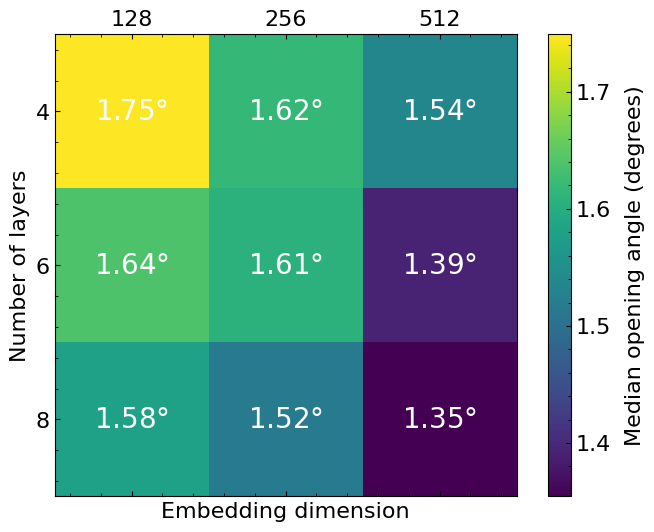

In [35]:
# plot as a 3x3 heatmap
fig, ax = plt.subplots(figsize=(8, 6))
# reshape the data to a 3x3 grid
heatmap_data = median_opening_angles.reshape(len(layers), len(emb_dims))

# create a heatmap
cax = ax.matshow(heatmap_data.T, cmap='viridis')
# add color bar
cbar = fig.colorbar(cax)
# add a little space between the color bar annd its label
cbar.set_label('Median opening angle (degrees)', fontsize=16, labelpad=10)


# set colorbar ticks from 1.3 to 1.8 at 0.1 intervals
cbar.set_ticks(np.arange(1.4, 1.7, 0.1))
# set tick size to 16
cbar.ax.tick_params(labelsize=16)

# set x and y ticks to be the layer and embedding dimension values
ax.set_xticks(np.arange(len(emb_dims)))
ax.set_yticks(np.arange(len(layers)))

ax.set_xticklabels(emb_dims)
ax.set_yticklabels(layers)
# set tick label size to 16
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
# set x and y labels
ax.set_xlabel('Embedding dimension', fontsize=16)
ax.set_ylabel('Number of layers', fontsize=16)

# add text annotations for each cell
for i in range(len(layers)):
    for j in range(len(emb_dims)):
            ax.text(j, i, f'${heatmap_data[j, i]:.2f}\\degree$', ha='center', va='center', color='white', fontsize=20, weight='bold')

plt.show()

### 🖼️ **Figure 7.10**  
**Training Time Scaling with Transformer Model Size**  

Scaling of the training time as a function of transformer model size. Training times are normalized to the time of the smallest model.


In [36]:
# Use average batch per second during training step (prevents influence of server downtime etc)
batch_per_second = [26.2, 19.7, 15.3, 17.7, 12.6, 9.8, 9.0, 6.3, 4.8] # 128_4, 128_6, 128_8, 256_4, 256_6, 256_8, 512_4, 512_6, 512_8
runtime = 1 / np.array(batch_per_second)
# normalize the runtime to the first value
runtime = runtime / runtime[0]

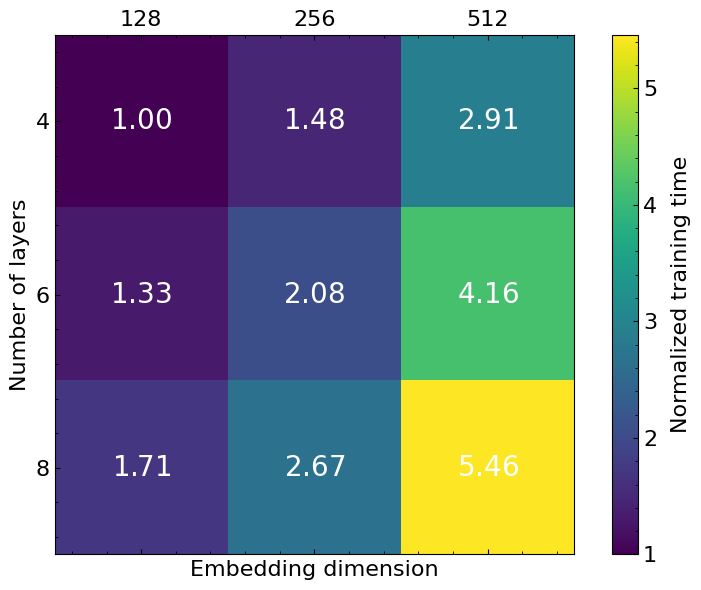

In [40]:
# make a runtime heatmap
fig, ax = plt.subplots(figsize=(8, 6))
# reshape the data to a 3x3 grid
heatmap_runtime = runtime.reshape(len(layers), len(emb_dims))

# create a heatmap
cax = ax.matshow(heatmap_runtime.T, cmap='viridis')
# add color bar
cbar = fig.colorbar(cax)
# add a little space between the color bar annd its label
cbar.set_label('Normalized training time', fontsize=16, labelpad=10)

#set colorbar ticks from 1 to 5 at integer intervals
cbar.set_ticks(np.arange(1,6, 1))
# set tick label size to 16
cbar.ax.tick_params(labelsize=16)

# set x and y ticks to be the layer and embedding dimension values
ax.set_xticks(np.arange(len(emb_dims)))
ax.set_yticks(np.arange(len(layers)))
ax.set_xticklabels(emb_dims)
ax.set_yticklabels(layers)
# set tick label size to 16
ax.tick_params(axis='both', labelsize=16)
# set x and y labels
ax.set_xlabel('Embedding dimension', fontsize=16)
ax.set_ylabel('Number of layers', fontsize=16)


# add text annotations for each cell
for i in range(len(layers)):
    for j in range(len(emb_dims)):
        ax.text(j, i, f'${heatmap_runtime[j, i]:.2f}$', ha='center', va='center', color='white', fontsize=20, weight='bold')

fig.tight_layout()

## ⚡️🧿 **Section 7.3: Pulse Maps vs. PMT‑fication**

In [41]:
# load predictions of the pulse and pmt models for the 22011 set
pulse_prediction = pd.read_csv("/groups/icecube/luc/Workspace/GraphNet/work/IceCube_transformer/predictions/22011/neutrino/1Mil_Pulses4.csv")
pmt_prediction = pd.read_csv("/groups/icecube/luc/Workspace/GraphNet/work/IceCube_transformer/predictions/22011/neutrino/1Mil_PMT.csv")

In [42]:
# calculate the opening angle between the predicted and true values
x_pred_pulse = pulse_prediction['x_pred']
y_pred_pulse = pulse_prediction['y_pred']
z_pred_pulse = pulse_prediction['z_pred']

x_truth_pulse = pulse_prediction['x_truth']
y_truth_pulse = pulse_prediction['y_truth']
z_truth_pulse = pulse_prediction['z_truth']

x_pred_pmt = pmt_prediction['x_pred']
y_pred_pmt = pmt_prediction['y_pred']
z_pred_pmt = pmt_prediction['z_pred']

x_truth_pmt = pmt_prediction['x_truth'] # same as x_truth_pulse
y_truth_pmt = pmt_prediction['y_truth'] # same as y_truth_pulse
z_truth_pmt = pmt_prediction['z_truth'] # same as z_truth_pulse

cos_opening_angle_pulse = (x_pred_pulse*x_truth_pulse + y_pred_pulse*y_truth_pulse + z_pred_pulse*z_truth_pulse) / (np.sqrt(x_pred_pulse**2 + y_pred_pulse**2 + z_pred_pulse**2) * np.sqrt(x_truth_pulse**2 + y_truth_pulse**2 + z_truth_pulse**2))
cos_opening_angle_pulse = np.clip(cos_opening_angle_pulse, -1, 1)
opening_angle_pulse = np.arccos(cos_opening_angle_pulse)
opening_angle_pulse = np.degrees(opening_angle_pulse)

cos_opening_angle_pmt = (x_pred_pmt*x_truth_pmt + y_pred_pmt*y_truth_pmt + z_pred_pmt*z_truth_pmt) / (np.sqrt(x_pred_pmt**2 + y_pred_pmt**2 + z_pred_pmt**2) * np.sqrt(x_truth_pmt**2 + y_truth_pmt**2 + z_truth_pmt**2))
cos_opening_angle_pmt = np.clip(cos_opening_angle_pmt, -1, 1)
opening_angle_pmt = np.arccos(cos_opening_angle_pmt)
opening_angle_pmt = np.degrees(opening_angle_pmt)

In [44]:
# Load the Thorsten Cut selection to create the selection mask
truth_total = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/22011/truth_4.parquet"
truth_TC_CC = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/CC_CRclean_MuonLike/22011/truth_4.parquet"
truth_total = pd.read_parquet(truth_total)
truth_TC_CC = pd.read_parquet(truth_TC_CC)

# create a mask for the TC_CC events
TC_CC_mask = truth_total['event_no'].isin(truth_TC_CC['event_no'])

# Print summary
print(f"Total number of events: {len(truth_total)}")
print(f"Number of TC_CC events: {len(truth_TC_CC)}")

Total number of events: 404014
Number of TC_CC events: 237393


### 🖼️ **Figure 7.11**  
**Opening Angle Distribution for Pulse Maps vs. PMTs**  

Distribution of the opening angle between the predicted and true neutrino direction for a transformer model trained on events represented as pulse maps versus PMTs. The distribution is truncated at 5°. The dashed lines indicate the median of the full distributions.


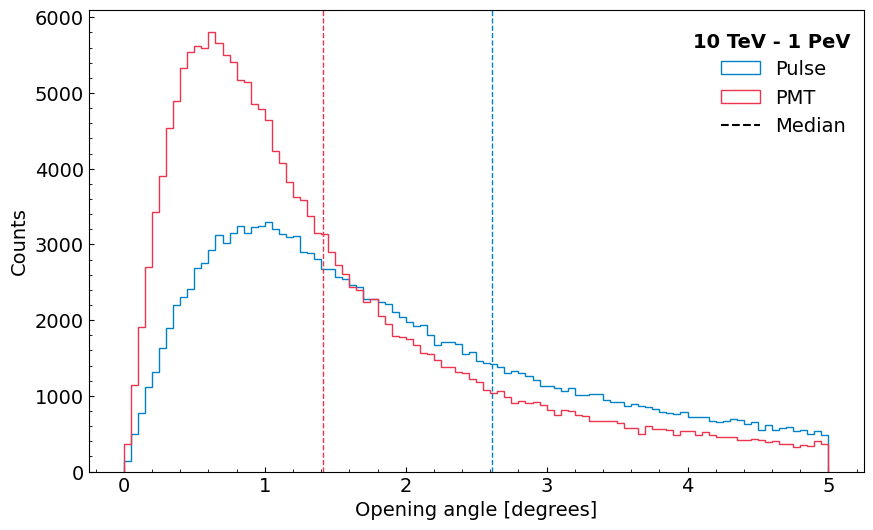

In [45]:
# plot the distribution of the opening angle for both the pulse and PMT prediction in the same plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(opening_angle_pulse[TC_CC_mask], bins=100, range=(0, 5), histtype='step', color=custom_colors[0], label = "Pulse")
ax.hist(opening_angle_pmt[TC_CC_mask], bins=100, range=(0, 5), histtype='step', color=custom_colors[1], label = "PMT")

ax.set_xlabel("Opening angle [degrees]", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ax.legend(loc="upper right", bbox_to_anchor=(1, 0.93), frameon=False)
plt.text(0.78, 0.95, "10 TeV - 1 PeV", transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')

# plot vertical dashed lines for the median
ax.axvline(opening_angle_pmt[TC_CC_mask].median(), color=custom_colors[1], linestyle='dashed', linewidth=1)
ax.axvline(opening_angle_pulse[TC_CC_mask].median(), color=custom_colors[0], linestyle='dashed', linewidth=1)

# add black dashed line to legend
ax.plot([], [], 'k--', label='Median')
ax.legend(loc="upper right", bbox_to_anchor=(1, 0.93), frameon=False, fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### 🖼️ **Figure 7.12**  
**Median Opening Angle vs. Pulses per Event**  

Median opening angle as a function of pulses per event for a transformer trained on pulse maps or PMT-fied data. The training data is in the energy range 10 TeV − 1 PeV. The models were truncated to a maximum sequence length of 256 during training, indicated by the black dashed line. The bottom plot shows the ratio in median of the PMT model to the pulse model.


In [46]:
pulse_data_path_22011 = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/22011/merged_part_4.db"

#===============LOAD DATA====================#
conn = sql.connect(pulse_data_path_22011)
query = "SELECT event_no FROM SRTInIcePulses"
data_pulse_22011 = pd.read_sql(query, conn)
conn.close()

num_pulses_per_event_22011 = data_pulse_22011['event_no'].value_counts(sort=False).values

In [47]:
# plot opening angle binned in number of pulses per event
pulse_bins = np.logspace(1, 5, 10)

median_opening_angle_pmt_pulses = []
median_opening_angle_pulse_pulses = []
counts_per_bin = []

upper_bounds_pmt = []
lower_bounds_pmt = []

upper_bounds_pulse = []
lower_bounds_pulse = []

quantile = 0.5


for i in range(len(pulse_bins)-1):
    mask = (num_pulses_per_event_22011 > pulse_bins[i]) & (num_pulses_per_event_22011 < pulse_bins[i+1])
    N_samples = np.sum(mask)
    counts_per_bin.append(N_samples)

    median_opening_angle_pmt_pulses.append(np.median(opening_angle_pmt[mask]))
    median_opening_angle_pulse_pulses.append(np.median(opening_angle_pulse[mask]))

    sorted_opening_angle_pmt = np.sort(opening_angle_pmt[mask])
    sorted_opening_angle_pulse = np.sort(opening_angle_pulse[mask])

    k_low = N_samples*quantile - np.sqrt(N_samples*quantile*(1-quantile))
    k_high = N_samples*quantile + np.sqrt(N_samples*quantile*(1-quantile))

    lower_bounds_pmt.append(sorted_opening_angle_pmt[int(k_low)])
    upper_bounds_pmt.append(sorted_opening_angle_pmt[int(k_high)])

    lower_bounds_pulse.append(sorted_opening_angle_pulse[int(k_low)])
    upper_bounds_pulse.append(sorted_opening_angle_pulse[int(k_high)])

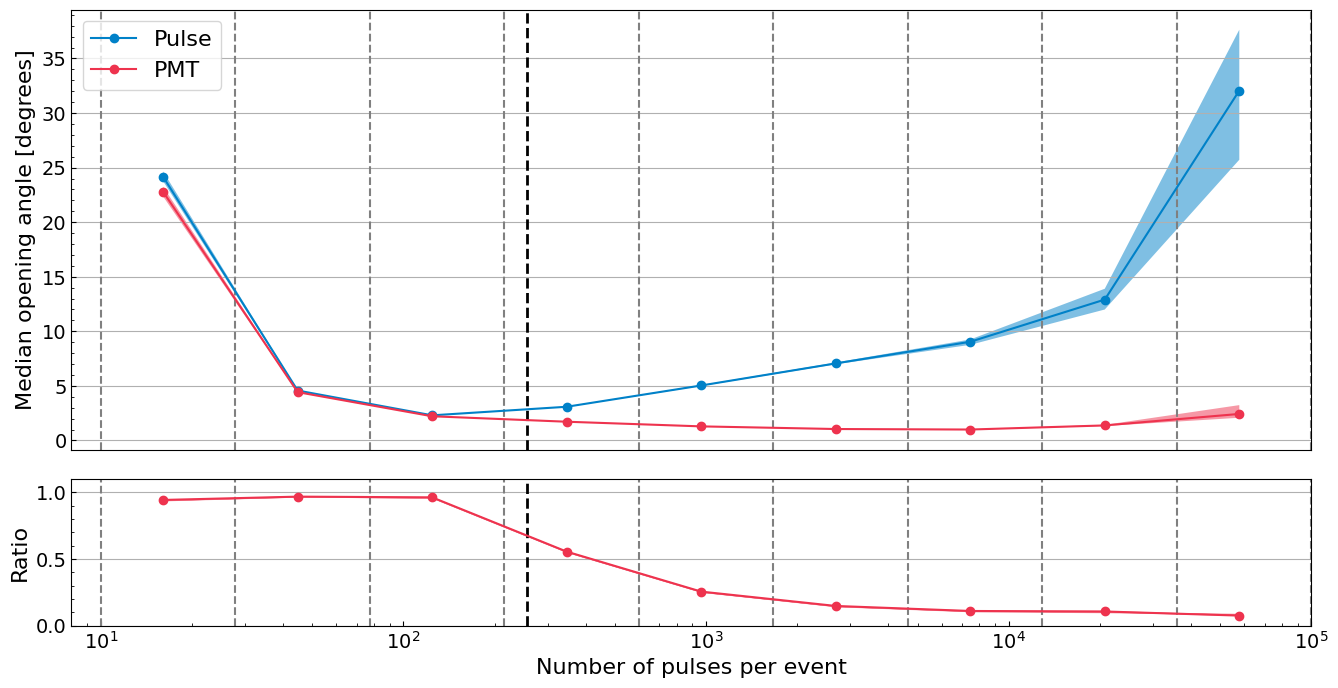

In [49]:
#Create figure and GridSpec with correct height ratios
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2], hspace=0.1)

# Create subplots with GridSpec
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Vertical dashed lines at bin edges
for pulse_bin in pulse_bins:
    if pulse_bin != 256:
        ax1.axvline(pulse_bin, color='gray', linestyle='--')

# draw thick black dashed line at 256
ax1.axvline(256, color='black', linestyle='--', linewidth=2)

bin_centers = (pulse_bins[:-1] + pulse_bins[1:]) / 2
bin_centers = bin_centers*0.85

# Plot median opening angle
ax1.plot(bin_centers, median_opening_angle_pulse_pulses, '-o', label='Pulse')
ax1.plot(bin_centers, median_opening_angle_pmt_pulses, '-o', label='PMT')
ax1.fill_between(bin_centers, lower_bounds_pulse, upper_bounds_pulse, alpha=0.5)
ax1.fill_between(bin_centers, lower_bounds_pmt, upper_bounds_pmt, alpha=0.5)
ax1.set_ylabel('Median opening angle [degrees]', fontsize=16)
ax1.legend(loc="upper left", fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(8, 1e5)

ax1.grid(axis='y')

ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# set tick size to 14
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Plot relative performance
median_opening_angle_pmt_pulses = np.array(median_opening_angle_pmt_pulses)
median_opening_angle_pulse_pulses = np.array(median_opening_angle_pulse_pulses)
baseline = median_opening_angle_pulse_pulses / median_opening_angle_pulse_pulses
# relative performance
relative = median_opening_angle_pmt_pulses / median_opening_angle_pulse_pulses
error_on_relative_upper = 1/median_opening_angle_pulse_pulses * (upper_bounds_pmt - median_opening_angle_pmt_pulses) - median_opening_angle_pmt_pulses / median_opening_angle_pulse_pulses**2 * (upper_bounds_pulse - median_opening_angle_pulse_pulses)
error_on_relative_lower = 1/median_opening_angle_pulse_pulses * (median_opening_angle_pmt_pulses - lower_bounds_pmt) - median_opening_angle_pmt_pulses / median_opening_angle_pulse_pulses**2 * (median_opening_angle_pulse_pulses - lower_bounds_pulse)

# Vertical dashed lines at bin edges
for pulse_bin in pulse_bins:
    if pulse_bin != 256:
        ax2.axvline(pulse_bin, color='gray', linestyle='--')

# draw thick black dashed line at 256
ax2.axvline(256, color='black', linestyle='--', linewidth=2)

ax2.plot(bin_centers, relative, '-o', color=custom_colors[1])
ax2.fill_between(bin_centers, relative - error_on_relative_lower, relative + error_on_relative_upper, 
                 alpha=0.5, color=custom_colors[1])
ax2.set_ylabel('Ratio', fontsize=16)
ax2.set_xlabel('Number of pulses per event', fontsize=16)
ax2.set_xscale('log')
ax2.set_ylim(0, 1.1)

# set tick size to 14
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)

# Enable grid on y-axis of relative performance plot
ax2.grid(axis='y')

# Show plot
plt.show()

### 🖼️ **Figure 7.13**  
**Median Opening Angle vs. PMTs per Event**  

Median opening angle of the PMT-fied transformer model as a function of PMTs per event before padding or truncation. The training data is in the energy range 10 TeV − 1 PeV. The model was truncated to a maximum sequence length of 256 PMTs during training, indicated by the black dashed line.


In [50]:
truth_Ndoms = truth_total['N_doms']

# plot as function of number of DOMs
dom_bins = np.array([8,16, 32, 64, 128, 256, 512, 1024, 2048])

median_opening_angle_pmt_doms = []
counts_per_bin = []

upper_bound_pmt_doms = []
lower_bound_pmt_doms = []

quantile = 0.5

for i in range(len(dom_bins)-1):
    mask = (truth_Ndoms > dom_bins[i]) & (truth_Ndoms < dom_bins[i+1])
    mask = mask & TC_CC_mask
    counts = np.sum(mask)

    median_opening_angle_pmt_doms.append(np.median(opening_angle_pmt[mask]))
    counts_per_bin.append(np.sum(mask))

    lower_bound, upper_bound = get_quantile_bounds(quantile, counts)
    sorted_opening_angle_pmt = np.sort(opening_angle_pmt[mask])
    lower_bound_pmt_doms.append(sorted_opening_angle_pmt[lower_bound])
    upper_bound_pmt_doms.append(sorted_opening_angle_pmt[upper_bound])

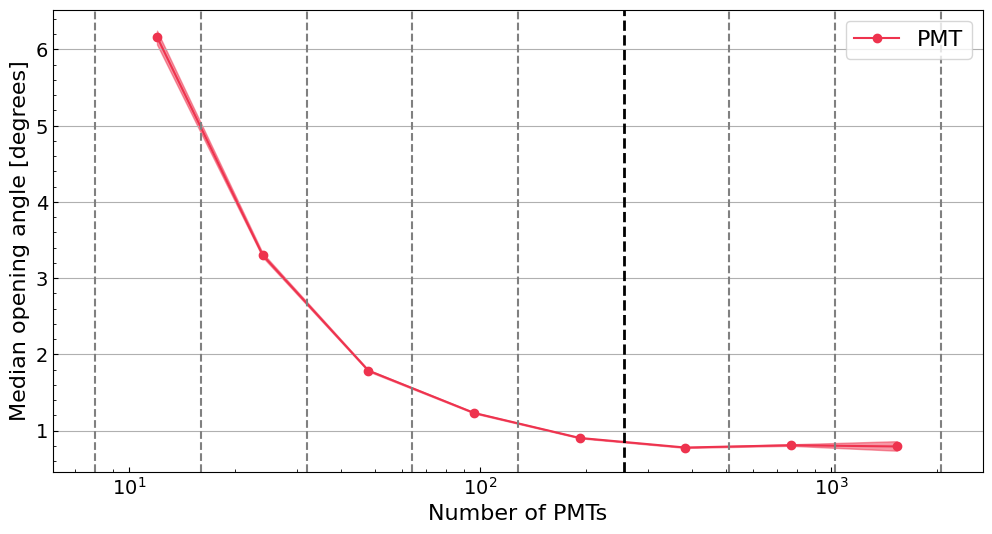

In [51]:
bin_centers = (dom_bins[:-1] + dom_bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.plot(bin_centers, median_opening_angle_pmt_doms, '-o', label='PMT', color=custom_colors[1])
plt.fill_between(bin_centers, lower_bound_pmt_doms, upper_bound_pmt_doms, alpha=0.5, color=custom_colors[1])
#plt.plot(bin_centers, median_opening_angle_pulse_doms, '-o',label='Pulse')
plt.xlabel('Number of PMTs', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Median opening angle [degrees]', fontsize=16)
plt.legend(fontsize=16)
plt.xscale('log')

# vertical dashed lines at bin edges
for i in range(len(dom_bins)):
    if dom_bins[i] == 256:
        plt.axvline(dom_bins[i], color='black', linestyle='--', linewidth=2)
    else:
        plt.axvline(dom_bins[i], color='gray', linestyle='--')

plt.grid(axis='y')
plt.show()

### 🖼️ **Figure 7.14**  
**Median Opening Angle vs. True Neutrino Energy**  

Median opening angle of the PMT-fied and pulse map transformer models as a function of true neutrino energy. The training and validation data is in the energy range 10 TeV − 1 PeV.


In [52]:
truth_energy = truth_total['energy']

# plot histogram of median opening angle pmt and pulse, binned in energy
energy_bins = np.logspace(4, 6, 9)

median_opening_angle_pmt = []
median_opening_angle_pulse = []

counts_per_bin = []

upper_bound_pmt = []
lower_bound_pmt = []    

upper_bound_pulse = []
lower_bound_pulse = []

quantile = 0.5


for i in range(len(energy_bins)-1):
    mask = (truth_energy > energy_bins[i]) & (truth_energy < energy_bins[i+1])
    mask = mask & TC_CC_mask
    counts = np.sum(mask)
    counts_per_bin.append(counts)

    median_opening_angle_pmt.append(np.median(opening_angle_pmt[mask]))
    median_opening_angle_pulse.append(np.median(opening_angle_pulse[mask]))

    lower_bound, upper_bound = get_quantile_bounds(quantile, counts)

    sorted_opening_angle_pmt = np.sort(opening_angle_pmt[mask])
    sorted_opening_angle_pulse = np.sort(opening_angle_pulse[mask])

    lower_bound_pmt.append(sorted_opening_angle_pmt[lower_bound])
    upper_bound_pmt.append(sorted_opening_angle_pmt[upper_bound])

    lower_bound_pulse.append(sorted_opening_angle_pulse[lower_bound])
    upper_bound_pulse.append(sorted_opening_angle_pulse[upper_bound])

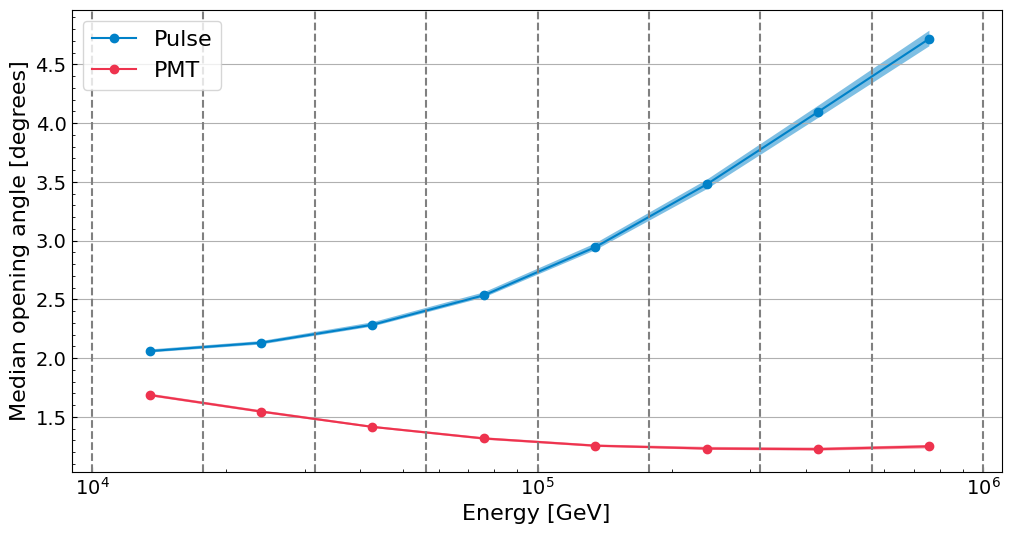

In [53]:
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
bin_centers = 0.97*bin_centers

plt.figure(figsize=(12, 6))
plt.plot(bin_centers, median_opening_angle_pulse, '-o',label='Pulse')
plt.plot(bin_centers, median_opening_angle_pmt, '-o', label='PMT')

plt.fill_between(bin_centers, lower_bound_pulse, upper_bound_pulse, alpha=0.5)
plt.fill_between(bin_centers, lower_bound_pmt, upper_bound_pmt, alpha=0.5)

plt.xscale('log')
plt.xlabel('Energy [GeV]', fontsize=16)
plt.ylabel('Median opening angle [degrees]', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left", fontsize=16)
plt.xlim(9e3, 1.1e6)

# vertical dashed lines at bin edges
for i in range(len(energy_bins)):
    plt.axvline(energy_bins[i], color='gray', linestyle='--')

plt.grid(axis='y')
plt.show()

In [54]:
# Load the predictions for the 22010 set (first 500k events)
pulse_pred_22010 = pd.read_csv("/groups/icecube/luc/Workspace/GraphNet/work/IceCube_transformer/predictions/22010/neutrino/1Mil_Pulses4_500.csv")
pmt_pred_22010 = pd.read_csv("/groups/icecube/luc/Workspace/GraphNet/work/IceCube_transformer/predictions/22010/neutrino/1Mil_PMT_truth4_500k.csv")

In [55]:
# calculate the opening angle between the predicted and true values
x_pred_pulse_22010 = pulse_pred_22010['x_pred']
y_pred_pulse_22010 = pulse_pred_22010['y_pred']
z_pred_pulse_22010 = pulse_pred_22010['z_pred']

x_pred_pmt_22010 = pmt_pred_22010['x_pred']
y_pred_pmt_22010 = pmt_pred_22010['y_pred']
z_pred_pmt_22010 = pmt_pred_22010['z_pred']

x_truth = pmt_pred_22010['x_truth']
y_truth = pmt_pred_22010['y_truth']
z_truth = pmt_pred_22010['z_truth']

cos_opening_angle_pulse_22010 = (x_pred_pulse_22010*x_truth + y_pred_pulse_22010*y_truth + z_pred_pulse_22010*z_truth) / (np.sqrt(x_pred_pulse_22010**2 + y_pred_pulse_22010**2 + z_pred_pulse_22010**2) * np.sqrt(x_truth**2 + y_truth**2 + z_truth**2))
cos_opening_angle_pmt_22010 = (x_pred_pmt_22010*x_truth + y_pred_pmt_22010*y_truth + z_pred_pmt_22010*z_truth) / (np.sqrt(x_pred_pmt_22010**2 + y_pred_pmt_22010**2 + z_pred_pmt_22010**2) * np.sqrt(x_truth**2 + y_truth**2 + z_truth**2))

cos_opening_angle_pulse_22010 = np.clip(cos_opening_angle_pulse_22010, -1, 1)
cos_opening_angle_pmt_22010 = np.clip(cos_opening_angle_pmt_22010, -1, 1)

opening_angle_pulse_22010 = np.arccos(cos_opening_angle_pulse_22010)
opening_angle_pmt_22010 = np.arccos(cos_opening_angle_pmt_22010)

opening_angle_pulse_22010 = np.degrees(opening_angle_pulse_22010)
opening_angle_pmt_22010 = np.degrees(opening_angle_pmt_22010)

In [57]:
truth_total_22010 = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/22010/truth_4.parquet"
truth_TC_CC_22010 = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/CC_CRclean_MuonLike/22010/truth_4.parquet"
truth_total_22010 = pd.read_parquet(truth_total_22010)
truth_total_22010 = truth_total_22010[:500000]
truth_TC_CC_22010 = pd.read_parquet(truth_TC_CC_22010)
TC_CC_mask_22010 = truth_total_22010['event_no'].isin(truth_TC_CC_22010['event_no'])

# print summary
print(f"Total number of events: {len(truth_total_22010)}")
print(f"Number of TC_CC events: {sum(TC_CC_mask_22010)}")

Total number of events: 500000
Number of TC_CC events: 212811


### 🖼️ **Figure 7.15**  
**Opening Angle Distribution for Pulse Maps vs. PMTs**  

Distribution of the opening angle between the predicted and true neutrino direction for a transformer model trained on events represented as pulse maps versus PMTs. The distribution is truncated at 15°. The dashed lines indicate the median of the full distributions.


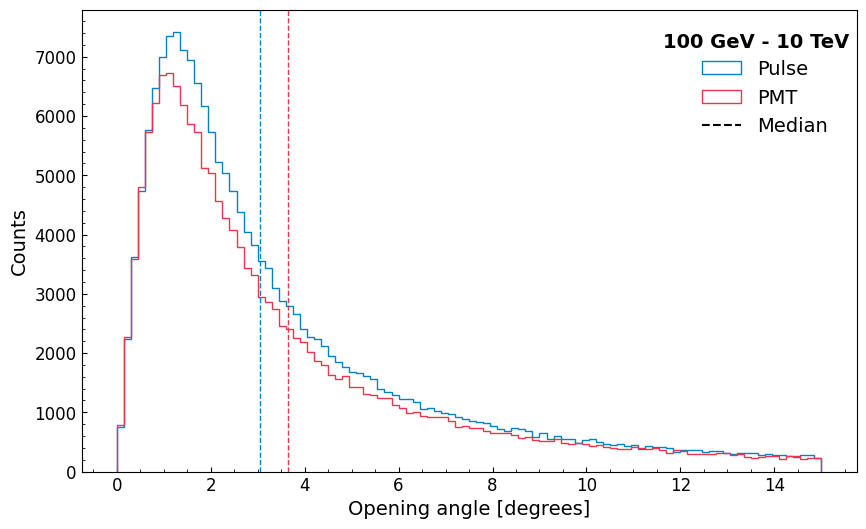

In [58]:
# plot the distribution of the opening angle for both the pulse and PMT prediction in the same plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(opening_angle_pulse_22010[TC_CC_mask_22010], bins=100, range=(0, 15), histtype='step', color=custom_colors[0], label = "Pulse")
ax.hist(opening_angle_pmt_22010[TC_CC_mask_22010], bins=100, range=(0, 15), histtype='step', color=custom_colors[1], label = "PMT")


ax.set_xlabel("Opening angle [degrees]", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

plt.text(0.75, 0.95, "100 GeV - 10 TeV", transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')

# plot vertical dashed lines for the median
ax.axvline(opening_angle_pmt_22010[TC_CC_mask_22010].median(), color=custom_colors[1], linestyle='dashed', linewidth=1)
ax.axvline(opening_angle_pulse_22010[TC_CC_mask_22010].median(), color=custom_colors[0], linestyle='dashed', linewidth=1)

# add black dashed line to legend
ax.plot([], [], 'k--', label='Median')
ax.legend(loc="upper right", bbox_to_anchor=(0.985, 0.93), frameon=False, fontsize=14)
plt.show()

### 🖼️ **Figure 7.16**  
**Median Opening Angle vs. Pulses per Event**  

Median opening angle as a function of pulses per event for a transformer trained on pulse maps or PMT-fied data. The training data is in the energy range 100 GeV − 10 TeV. The models were truncated to a maximum sequence length of 256 during training, indicated by the black dashed line. The bottom plot shows the ratio in median of the PMT model to the pulse model.


In [59]:
pulse_data_path_22010 = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/22010/merged_part_4.db"

#===============LOAD DATA====================#
conn = sql.connect(pulse_data_path_22010)
query = "SELECT event_no FROM SRTInIcePulses LIMIT 30_000_000"
data_pulse_22010 = pd.read_sql(query, conn)
conn.close()

num_pulses_per_event_22010 = data_pulse_22010['event_no'].value_counts(sort=False).values
num_pulses_per_event_22010 = num_pulses_per_event_22010[:500000]

In [60]:
# plot as function of number of pulses per event
pulse_bins = np.array([8,16, 32, 64, 128, 256, 512, 1024, 2048])

median_opening_angle_pmt_pulses = []
median_opening_angle_pulse_pulses = []
counts_per_bin = []

upper_bounds_pmt = []
lower_bounds_pmt = []

upper_bounds_pulse = []
lower_bounds_pulse = []

quantile = 0.5


for i in range(len(pulse_bins)-1):
    mask = (num_pulses_per_event_22010 > pulse_bins[i]) & (num_pulses_per_event_22010 < pulse_bins[i+1])
    mask = mask & TC_CC_mask_22010
    N_samples = np.sum(mask)
    counts_per_bin.append(N_samples)

    median_opening_angle_pmt_pulses.append(np.median(opening_angle_pmt_22010[mask]))
    median_opening_angle_pulse_pulses.append(np.median(opening_angle_pulse_22010[mask]))

    sorted_opening_angle_pmt_22010 = np.sort(opening_angle_pmt_22010[mask])
    sorted_opening_angle_pulse_22010 = np.sort(opening_angle_pulse_22010[mask])

    k_low = N_samples*quantile - np.sqrt(N_samples*quantile*(1-quantile))
    k_high = N_samples*quantile + np.sqrt(N_samples*quantile*(1-quantile))

    lower_bounds_pmt.append(sorted_opening_angle_pmt_22010[int(k_low)])
    upper_bounds_pmt.append(sorted_opening_angle_pmt_22010[int(k_high)])

    lower_bounds_pulse.append(sorted_opening_angle_pulse_22010[int(k_low)])
    upper_bounds_pulse.append(sorted_opening_angle_pulse_22010[int(k_high)])

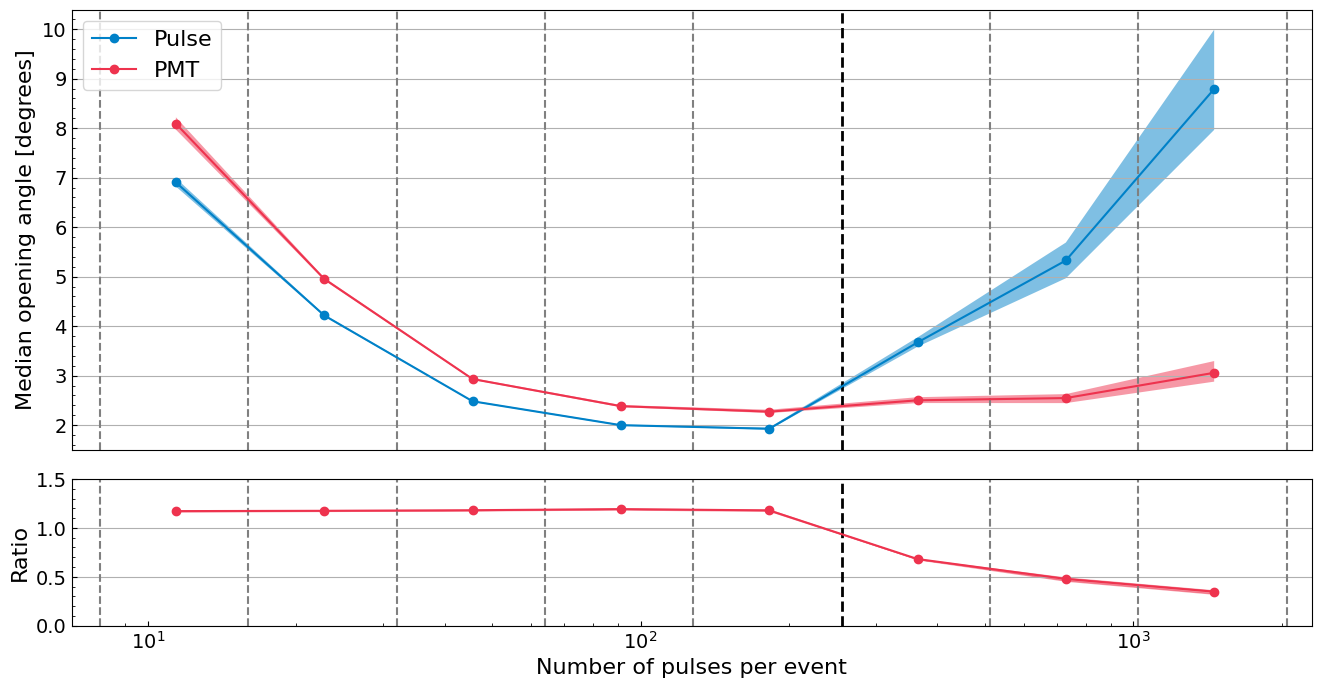

In [ ]:
#Create figure and GridSpec with correct height ratios
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2], hspace=0.1)

# Create subplots with GridSpec
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Vertical dashed lines at bin edges
for pulse_bin in pulse_bins:
    if pulse_bin != 256:
        ax1.axvline(pulse_bin, color='gray', linestyle='--')

# draw thick black dashed line at 256
ax1.axvline(256, color='black', linestyle='--', linewidth=2)

bin_centers = (pulse_bins[:-1] + pulse_bins[1:]) / 2
bin_centers = bin_centers*0.95

# Plot median opening angle
ax1.plot(bin_centers, median_opening_angle_pulse_pulses, '-o', label='Pulse')
ax1.plot(bin_centers, median_opening_angle_pmt_pulses, '-o', label='PMT')
ax1.fill_between(bin_centers, lower_bounds_pulse, upper_bounds_pulse, alpha=0.5)
ax1.fill_between(bin_centers, lower_bounds_pmt, upper_bounds_pmt, alpha=0.5)
ax1.set_ylabel('Median opening angle [degrees]', fontsize=16)
ax1.legend(loc="upper left", fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(7, 2300)

ax1.grid(axis='y')

ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# set tick size to 14
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Plot relative performance
median_opening_angle_pmt_pulses = np.array(median_opening_angle_pmt_pulses)
median_opening_angle_pulse_pulses = np.array(median_opening_angle_pulse_pulses)
baseline = median_opening_angle_pulse_pulses / median_opening_angle_pulse_pulses
# relative performance
relative = median_opening_angle_pmt_pulses / median_opening_angle_pulse_pulses
error_on_relative_upper = 1/median_opening_angle_pulse_pulses * (upper_bounds_pmt - median_opening_angle_pmt_pulses) - median_opening_angle_pmt_pulses / median_opening_angle_pulse_pulses**2 * (upper_bounds_pulse - median_opening_angle_pulse_pulses)
error_on_relative_lower = 1/median_opening_angle_pulse_pulses * (median_opening_angle_pmt_pulses - lower_bounds_pmt) - median_opening_angle_pmt_pulses / median_opening_angle_pulse_pulses**2 * (median_opening_angle_pulse_pulses - lower_bounds_pulse)

# Vertical dashed lines at bin edges
for pulse_bin in pulse_bins:
    if pulse_bin != 256:
        ax2.axvline(pulse_bin, color='gray', linestyle='--')

# draw thick black dashed line at 256
ax2.axvline(256, color='black', linestyle='--', linewidth=2)

ax2.plot(bin_centers, relative, '-o', color=custom_colors[1])
ax2.fill_between(bin_centers, relative - error_on_relative_lower, relative + error_on_relative_upper, 
                 alpha=0.5, color=custom_colors[1])
ax2.set_ylabel('Ratio', fontsize=16)
ax2.set_xlabel('Number of pulses per event', fontsize=16)
ax2.set_xscale('log')
ax2.set_ylim(0, 1.5)

# set tick size to 14
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)

# Enable grid on y-axis of relative performance plot
ax2.grid(axis='y')

# Show plot
plt.show()

### 🖼️ **Figure 7.17**  
**Median Opening Angle vs. True Neutrino Energy**  

Median opening angle of the PMT-fied and pulse map transformer models as a function of true neutrino energy. The training and validation data is in the energy range 100 GeV − 10 TeV. The bottom plot shows the ratio in median of the PMT model to the pulse model.


In [62]:
truth_energy_22010 = truth_total_22010['energy']

# plot histogram of median opening angle pmt and pulse, binned in energy
energy_bins = np.logspace(2, 4, 9)

median_opening_angle_pmt_22010 = []
median_opening_angle_pulse_22010 = []

counts_per_bin = []

upper_bound_pmt_22010 = []
lower_bound_pmt_22010 = []    

upper_bound_pulse_22010 = []
lower_bound_pulse_22010 = []

quantile = 0.5


for i in range(len(energy_bins)-1):
    mask = (truth_energy_22010 > energy_bins[i]) & (truth_energy_22010 < energy_bins[i+1])
    mask = mask & TC_CC_mask_22010
    counts = np.sum(mask)
    counts_per_bin.append(counts)

    median_opening_angle_pmt_22010.append(np.median(opening_angle_pmt_22010[mask]))
    median_opening_angle_pulse_22010.append(np.median(opening_angle_pulse_22010[mask]))

    lower_bound, upper_bound = get_quantile_bounds(quantile, counts)

    sorted_opening_angle_pmt_22010 = np.sort(opening_angle_pmt_22010[mask])
    sorted_opening_angle_pulse_22010 = np.sort(opening_angle_pulse_22010[mask])

    lower_bound_pmt_22010.append(sorted_opening_angle_pmt_22010[lower_bound])
    upper_bound_pmt_22010.append(sorted_opening_angle_pmt_22010[upper_bound])

    lower_bound_pulse_22010.append(sorted_opening_angle_pulse_22010[lower_bound])
    upper_bound_pulse_22010.append(sorted_opening_angle_pulse_22010[upper_bound])

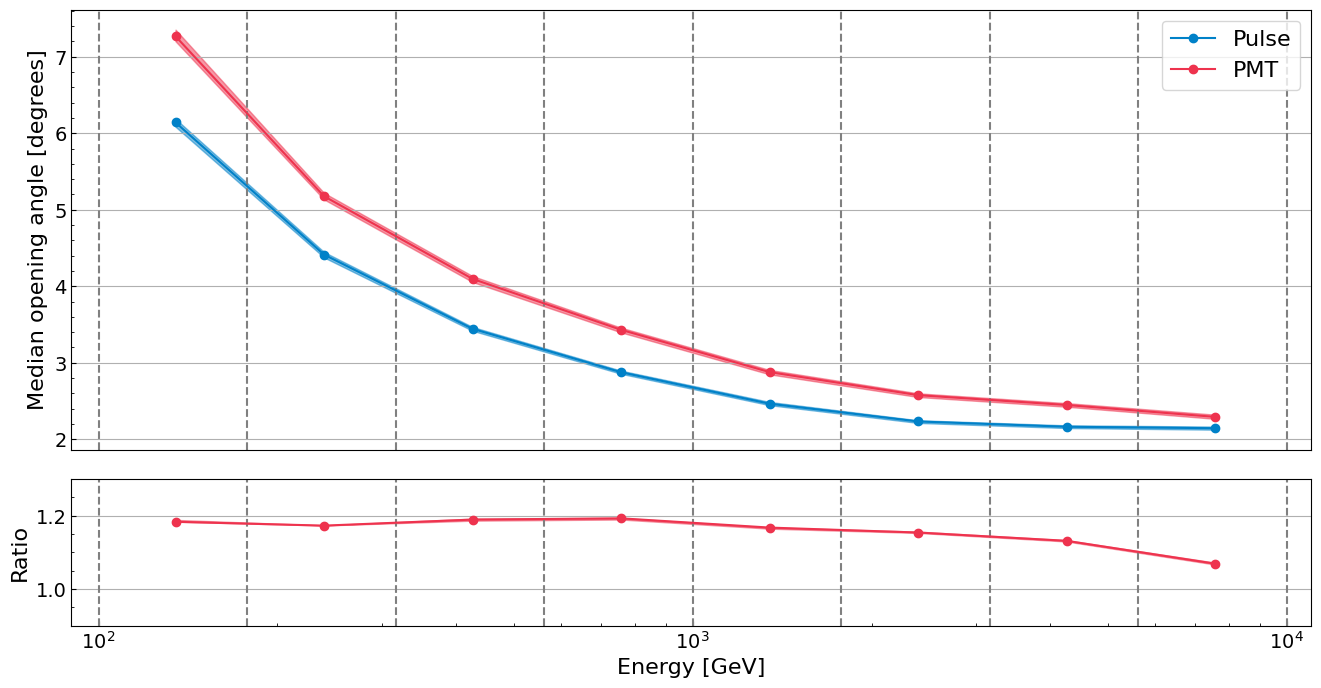

In [64]:
median_opening_angle_pmt_22010 = np.array(median_opening_angle_pmt_22010)
median_opening_angle_pulse_22010 = np.array(median_opening_angle_pulse_22010)

# relative performance
relative = median_opening_angle_pmt_22010 / median_opening_angle_pulse_22010
error_on_relative_upper = 1/median_opening_angle_pulse_22010 * (upper_bound_pmt_22010 - median_opening_angle_pmt_22010) - median_opening_angle_pmt_22010 / median_opening_angle_pulse_22010**2 * (upper_bound_pulse_22010 - median_opening_angle_pulse_22010)
error_on_relative_lower = 1/median_opening_angle_pulse_22010 * (median_opening_angle_pmt_22010 - lower_bound_pmt_22010) - median_opening_angle_pmt_22010 / median_opening_angle_pulse_22010**2 * (median_opening_angle_pulse_22010 - lower_bound_pulse_22010)

# plot as function of energy
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2], hspace=0.1)

# Create subplots with GridSpec
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Vertical dashed lines at bin edges
for i in range(len(energy_bins)):
    ax1.axvline(energy_bins[i], color='gray', linestyle='--')

# Plot median opening angle
bin_centers = 0.97*(energy_bins[:-1] + energy_bins[1:]) / 2
ax1.plot(bin_centers, median_opening_angle_pulse_22010, '-o', label='Pulse', color=custom_colors[0])
ax1.plot(bin_centers, median_opening_angle_pmt_22010, '-o', label='PMT', color=custom_colors[1])
ax1.fill_between(bin_centers, lower_bound_pulse_22010, upper_bound_pulse_22010, alpha=0.5, color=custom_colors[0])
ax1.fill_between(bin_centers, lower_bound_pmt_22010, upper_bound_pmt_22010, alpha=0.5, color=custom_colors[1])
ax1.set_ylabel('Median opening angle [degrees]', fontsize=16)
ax1.legend(loc="upper right", fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(9e1, 1.1e4)
ax1.grid(axis='y')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# set tick size to 14
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Plot relative performance
median_opening_angle_pmt_22010 = np.array(median_opening_angle_pmt_22010)
median_opening_angle_pulse_22010 = np.array(median_opening_angle_pulse_22010)

# relative performance
relative = median_opening_angle_pmt_22010 / median_opening_angle_pulse_22010
error_on_relative_upper = 1/median_opening_angle_pulse_22010 * (upper_bound_pmt_22010 - median_opening_angle_pmt_22010) - median_opening_angle_pmt_22010 / median_opening_angle_pulse_22010**2 * (upper_bound_pulse_22010 - median_opening_angle_pulse_22010)
error_on_relative_lower = 1/median_opening_angle_pulse_22010 * (median_opening_angle_pmt_22010 - lower_bound_pmt_22010) - median_opening_angle_pmt_22010 / median_opening_angle_pulse_22010**2 * (median_opening_angle_pulse_22010 - lower_bound_pulse_22010)

# Vertical dashed lines at bin edges
for i in range(len(energy_bins)):
    ax2.axvline(energy_bins[i], color='gray', linestyle='--')

ax2.plot(bin_centers, relative, '-o', color=custom_colors[1])
ax2.fill_between(bin_centers, relative - error_on_relative_lower, relative + error_on_relative_upper, 
                 alpha=0.5, color=custom_colors[1])
ax2.set_ylabel('Ratio', fontsize=16)
ax2.set_xlabel('Energy [GeV]', fontsize=16)
ax2.set_xscale('log')
ax2.set_xlim(9e1, 1.1e4)
ax2.set_ylim(0.9, 1.3)

# set tick size to 14
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)

# Enable grid on y-axis of relative performance plot
ax2.grid(axis='y')

# Show plot
plt.show()